# Deconvolve
### Dependencies

In [1]:
import os
import numpy as np
import healpy as hp
import fitsio
import matplotlib.pyplot as plt
import matplotlib as mpl
import camb
from camb.sources import SplinedSourceWindow
from heracles.fields import Positions, Shears
from heracles.maps import Healpix
from heracles.maps import transform
from heracles.twopoint import angular_power_spectra, bin2pt
from heracles.fields import Visibility, Weights
from heracles.twopoint import mixing_matrices
from heracles.maps import map_catalogs
from heracles.core import TocDict

In [2]:
ind = {}
ind[('G_B', 'G_B', 0, 0)] = np.arange(0, 15)
ind[('G_E', 'G_E', 0, 0)] = np.arange(15, 30)
ind[('P', 'P', 0, 0)]     = np.arange(30, 45)

def to_dict(v, ind):
    d = {}
    for i, key in enumerate(ind.keys()):
        d[key] = v[ind[key]]
    return d

def cov_to_dict(cov, ind):
    d = {}
    for i, key in enumerate(ind.keys()):
        d[key] = cov[ind[key]][:, ind[key]]
    return d

lmax = 1000
l = np.arange(lmax+1)
bin_num = 15

fields_a = np.unique([i[0] for i in ind.keys()])
fields_b = np.unique([i[1] for i in ind.keys()])

# Binning
#bin_edges = np.logspace(np.log10(10), np.log10(lmax+1), bin_num+1).astype(int)
bin_edges = np.linspace(10, lmax+1, bin_num+1).astype(int)
B = np.diag(np.ones(lmax+1))
B = bin2pt(B, bin_edges, 'B')
binned_ls = B['L']
B = B['B']

q = B @ l

In [25]:
mask_type = "patch_log"
forward_d   = np.load("../scripts/samples/{}/data.npy".format(mask_type))
forward_t   = np.load("../scripts/samples/{}/forward_theory.npy".format(mask_type))
inversion_d = np.load("../scripts/samples/{}/inversion_data.npy".format(mask_type))
inversion_t = np.load("../scripts/samples/{}/theory.npy".format(mask_type))
master_t    = np.load("../scripts/samples/{}/master_theory.npy".format(mask_type))
master_d    = np.load("../scripts/samples/{}/master_data.npy".format(mask_type))
polspice_d  = np.load("../scripts/samples/{}/polspice_data.npy".format(mask_type))
npolspice_d = np.load("../scripts/samples/{}/naive_polspice_data.npy".format(mask_type))

In [26]:
qq = np.concatenate([q, q, q])

In [27]:
forward_d__m =  np.mean(forward_d, axis=0)
forward_t__m = np.mean(forward_t, axis=0)
forward_d__cov = np.cov(forward_d.T)
forward_d__s = np.sqrt(np.diag(forward_d__cov))
forward_t__cov = np.eye(len(forward_t__m))*(2 * forward_t__m**2)/(2*qq+1)
forward_t__s = np.sqrt(np.diag(forward_t__cov))

inversion_d__m = np.mean(inversion_d, axis=0)
inversion_t__m = np.mean(inversion_t, axis=0)
inversion_d__cov = np.cov(inversion_d.T)
inversion_d__s = np.sqrt(np.diag(inversion_d__cov))
inversion_t__cov = np.eye(len(inversion_t__m))*(2 * inversion_t__m**2)/(2*qq+1)
inversion_t__s = np.sqrt(np.diag(inversion_t__cov))

master_d__m = np.mean(master_d, axis=0)
master_t__m = np.mean(master_t, axis=0)
master_d__cov = np.cov(master_d.T)
master_d__s = np.sqrt(np.diag(master_d__cov))
master_t__cov = np.eye(len(master_t__m))*(2 * master_t__m**2)/(2*qq+1)
master_t__s = np.sqrt(np.diag(master_t__cov))

polspice_d__m = np.mean(polspice_d, axis=0)
polspice_d__cov = np.cov(polspice_d.T)
polspice_d__s = np.sqrt(np.diag(polspice_d__cov))
polspice_t__cov = np.eye(len(inversion_t__m))*(2 * inversion_t__m**2)/(2*qq+1)
polspice_t__s = np.sqrt(np.diag(polspice_t__cov))

npolspice_d__m = np.mean(npolspice_d, axis=0)
npolspice_d__cov = np.cov(npolspice_d.T)
npolspice_d__s = np.sqrt(np.diag(npolspice_d__cov))
npolspice_t__cov = np.eye(len(inversion_t__m))*(2 * inversion_t__m**2)/(2*qq+1)
npolspice_t__s = np.sqrt(np.diag(npolspice_t__cov))


In [28]:
forward_t__m = to_dict(forward_t__m, ind)
forward_d__m = to_dict(forward_d__m, ind)
forward_d__cov = cov_to_dict(forward_d__cov, ind)
forward_d__s = to_dict(forward_d__s, ind)
forward_t__cov = cov_to_dict(forward_t__cov, ind)
forward_t__s = to_dict(forward_t__s, ind)

inversion_t__m = to_dict(inversion_t__m, ind)
inversion_d__m = to_dict(inversion_d__m, ind)
inversion_d__cov = cov_to_dict(inversion_d__cov, ind)
inversion_d__s = to_dict(inversion_d__s, ind)
inversion_t__cov = cov_to_dict(inversion_t__cov, ind)
inversion_t__s = to_dict(inversion_t__s, ind)

master_t__m = to_dict(master_t__m, ind)
master_d__m = to_dict(master_d__m, ind)
master_d__cov = cov_to_dict(master_d__cov, ind)
master_d__s = to_dict(master_d__s, ind)
master_t__cov = cov_to_dict(master_t__cov, ind)
master_t__s = to_dict(master_t__s, ind)

polspice_d__m = to_dict(polspice_d__m, ind)
polspice_d__cov = cov_to_dict(polspice_d__cov, ind)
polspice_d__s = to_dict(polspice_d__s, ind)
polspice_t__cov = cov_to_dict(polspice_t__cov, ind)
polsice_t__s = to_dict(polspice_t__s, ind)

npolspice_d__m = to_dict(npolspice_d__m, ind)
npolspice_d__cov = cov_to_dict(npolspice_d__cov, ind)
npolspice_d__s = to_dict(npolspice_d__s, ind)
npolspice_t__cov = cov_to_dict(npolspice_t__cov, ind)
npolsice_t__s = to_dict(npolspice_t__s, ind)

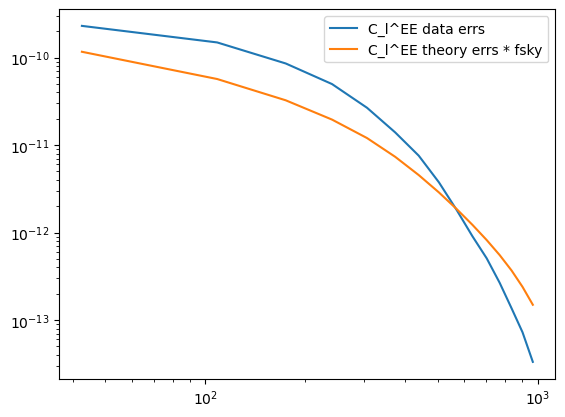

In [29]:
d_err = np.sqrt(np.diag(forward_d__cov[('G_E', 'G_E', 0, 0)]))
t_err = np.sqrt(np.diag(inversion_t__cov[('G_E', 'G_E', 0, 0)]))
t_err = t_err * 0.09381103515625 # 0.03073516736427943

plt.plot(q, d_err, label="C_l^EE data errs")
plt.plot(q, t_err, label="C_l^EE theory errs * fsky")
plt.legend()
plt.loglog()
plt.show()

In [30]:
def plot_triangle(cls, covs, colors=['b', 'r', 'g', 'm']):
    figure, axis = plt.subplots(3, 3, figsize=(5*3, 5*3))
    for i, s1 in enumerate(fields_a):
        for j, s2 in enumerate(fields_b):
            proposed_key = (s1, s2, 0, 0)
            if proposed_key in list(ind.keys()):
                #print(proposed_key) 
                for n, cl_name in enumerate(list(cls.keys())):
                    #print(cl_name)
                    cl = cls[cl_name][proposed_key]
                    cov = covs[cl_name][proposed_key]
                    err = np.sqrt(np.diag(cov))
                    axis[i, j].plot(B @ l, cl, color=colors[n], label=cl_name)
                    axis[i, j].fill_between(B @ l, cl-err, cl+err, color=colors[n], alpha=0.3)
                
                axis[i, j].set_xscale('log')
                axis[i, j].set_yscale('log')
                axis[i, j].set_title(f"{s1}x{s2}")
                axis[i, j].set_xlabel(r"$\ell$")
                axis[i, j].set_ylabel(r"$C_\ell$")
                axis[i, j].grid()
                axis[i, j].legend()
            else:
                axis[i, j].axis('off')
    plt.show()

def plot_wcovs(cls, covs, dness,
               colors=['b', 'r', 'g', 'm'],
               save_to=None):
    figure, axis = plt.subplots(2, 3, figsize=(10, 6))
    figure.subplots_adjust(wspace=0.3, hspace=0.01)
    for i, s1 in enumerate(fields_a):
            proposed_key = (s1, s1, 0, 0)
            #print(proposed_key) 
            for n, cl_name in enumerate(list(cls.keys())):
                #print(cl_name)
                cl = cls[cl_name][proposed_key]
                cov = covs[cl_name][proposed_key]
                err = np.sqrt(np.diag(cov))
                corr = cov/np.outer(err, err)
                axis[0, i].plot(B @ l, cl, color=colors[n], label=cl_name)
                axis[0, i].fill_between(B @ l, cl-err, cl+err, color=colors[n], alpha=0.3)
                axis[0, i].set_xscale('log')
                axis[0, i].set_yscale('log')
                axis[0, i].set_title(f"{s1}x{s1}")
                axis[0, i].set_xlabel(r"$\ell$")
                axis[0, i].set_xlim([np.min(B @ l), np.max(B @ l)])
                if i == 0:
                    axis[0, i].set_ylabel(r"$C_\ell$")
                axis[0, i].grid()
                axis[0, i].legend()
            
            d = dness[proposed_key]
            im = axis[1, i].imshow(corr, aspect="auto", cmap='bwr',
                                      vmin=-1, vmax=1,
                              origin='lower', extent=[0, lmax, 0, lmax])
            title = r"$\gamma = {}$".format(d)
            axis[1, i].set_title(title, y=0.8)
            axis[1, i].set_xlabel(r"$\ell$")
    cbar_ax = figure.add_axes([0.905, 0.11, 0.02, 0.38])
    figure.colorbar(im, cax=cbar_ax)
    if save_to is not None:
        path = "/home/jaimerz/Desktop/deconvolve_paper/"
        plt.savefig(path+save_to)
    plt.show()
    

In [31]:
def get_dness(covs):
    dnesss = {}
    for cov_name in list(covs.keys()):
        cov = covs[cov_name]
        err = np.sqrt(np.diag(cov))+1*10**-20
        corr = cov/np.outer(err, err)
        (m, n) = corr.shape
        d = 0
        od = 0
        for i in range(m):
            for j in range(n):
                if i == j:
                    d = d+corr[i, j]**2
                else:
                    od = od + corr[i, j]**2
        dness = od/(d+0.00005)
        dness = np.round(dness,3)
        print(cov_name, "-->", dness)
        dnesss[cov_name] = dness
    return dnesss

def get_dness_progress(ensemble, ind):
    covss = [np.cov(ensemble[:100*(i)].T) for i in range(1, 8)]
    covss = [cov_to_dict(covs, ind) for covs in covss]
    dnessss = {}
    for cov_name in list(covss[0].keys()):
        dnesss = []
        for covs in covss:
            cov = covs[cov_name]
            err = np.sqrt(np.diag(cov))+1*10**-20
            corr = cov/np.outer(err, err)
            (m, n) = corr.shape
            d = 0
            od = 0
            for i in range(m):
                for j in range(n):
                    if i == j:
                        d = d+corr[i, j]**2
                    else:
                        od = od + corr[i, j]**2
            dness = od/(d+0.00005)
            dness = np.round(dness,3)
            dnesss.append(dness)
        dnessss[cov_name] = dnesss
    return dnessss


In [32]:
forward_progress = get_dness_progress(forward_d, ind)
inversion_progress = get_dness_progress(inversion_d, ind)
master_progress = get_dness_progress(master_d, ind)
pols_progress = get_dness_progress(polspice_d, ind)
npols_progress = get_dness_progress(npolspice_d, ind)

Text(0.5, 1.0, 'Forward')

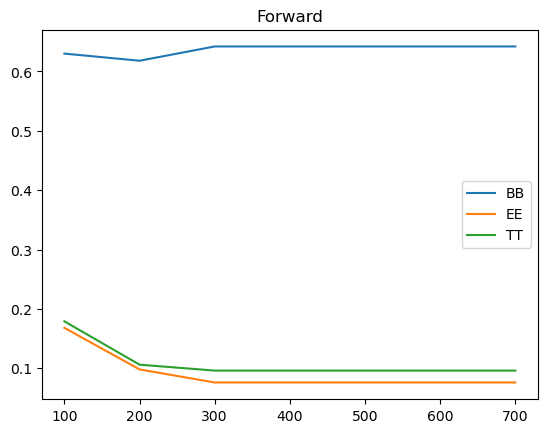

In [33]:
x = 100*np.arange(1, 8)
plt.plot(x, forward_progress[('G_B', 'G_B', 0, 0)], label="BB")
plt.plot(x, forward_progress[('G_E', 'G_E', 0, 0)], label="EE")
plt.plot(x, forward_progress[('P', 'P', 0, 0)], label="TT")
plt.legend()
plt.title("Forward")

Text(0.5, 1.0, 'Inversion')

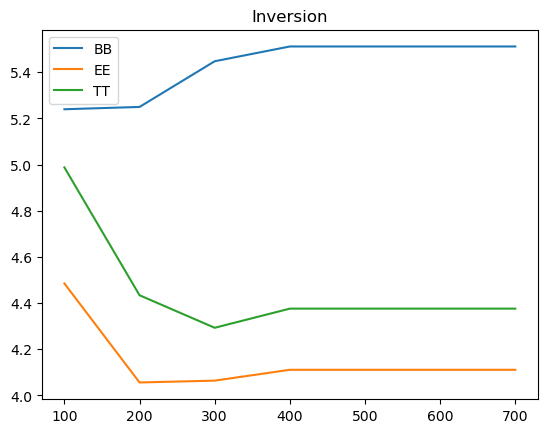

In [34]:
x = 100*np.arange(1, 8)
plt.plot(x, inversion_progress[('G_B', 'G_B', 0, 0)], label="BB")
plt.plot(x, inversion_progress[('G_E', 'G_E', 0, 0)], label="EE")
plt.plot(x, inversion_progress[('P', 'P', 0, 0)], label="TT")
plt.legend()
plt.title("Inversion")

Text(0.5, 1.0, 'Master')

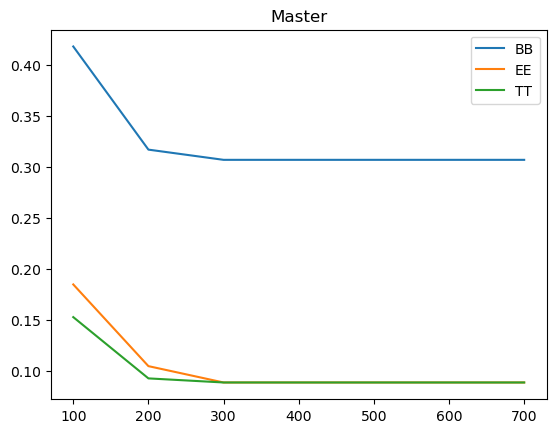

In [35]:
x = 100*np.arange(1, 8)
plt.plot(x, master_progress[('G_B', 'G_B', 0, 0)], label="BB")
plt.plot(x, master_progress[('G_E', 'G_E', 0, 0)], label="EE")
plt.plot(x, master_progress[('P', 'P', 0, 0)], label="TT")
plt.legend()
plt.title("Master")

Text(0.5, 1.0, 'Polspice')

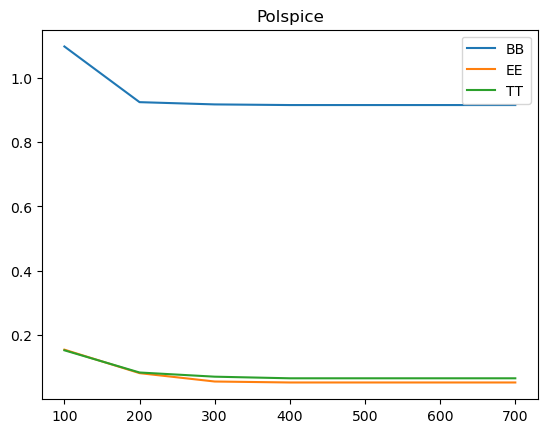

In [36]:
x = 100*np.arange(1, 8)
plt.plot(x, pols_progress[('G_B', 'G_B', 0, 0)], label="BB")
plt.plot(x, pols_progress[('G_E', 'G_E', 0, 0)], label="EE")
plt.plot(x, pols_progress[('P', 'P', 0, 0)], label="TT")
plt.legend()
plt.title("Polspice")

Text(0.5, 1.0, 'Naive Polspice')

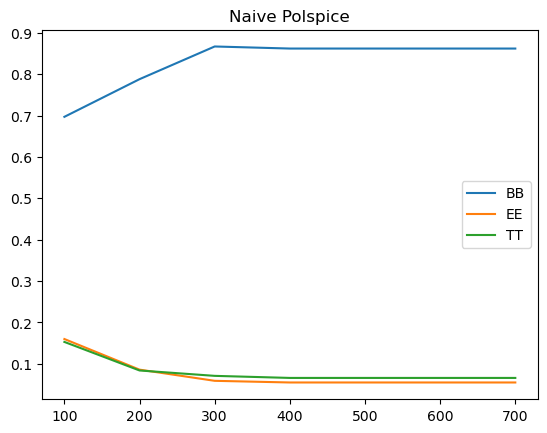

In [37]:
x = 100*np.arange(1, 8)
plt.plot(x, npols_progress[('G_B', 'G_B', 0, 0)], label="BB")
plt.plot(x, npols_progress[('G_E', 'G_E', 0, 0)], label="EE")
plt.plot(x, npols_progress[('P', 'P', 0, 0)], label="TT")
plt.legend()
plt.title("Naive Polspice")

In [38]:
for_cls = {'forward_t': forward_t__m, 'forward_d': forward_d__m}
for_covs = {'forward_t': forward_t__cov, 'forward_d': forward_d__cov}

inv_cls = {'inversion_t': inversion_t__m, 'inversion_d': inversion_d__m}
inv_covs = {'inversion_t': inversion_t__cov, 'inversion_d': inversion_d__cov}

master_cls = {'master_t': master_t__m, 'master_d': master_d__m}
master_covs = {'master_t': master_t__cov, 'master_d': master_d__cov}

polspice_cls = {'polspice_t': inversion_t__m, 'polspice_d': polspice_d__m}
polspice_covs = {'polspice_t': inversion_t__cov, 'polspice_d': polspice_d__cov}

npolspice_cls = {'npolspice_t': inversion_t__m, 'npolspice_d': npolspice_d__m}
npolspice_covs = {'npolspice_t': inversion_t__cov, 'npolspice_d': npolspice_d__cov}

In [39]:
for_dness = get_dness(forward_d__cov)
inv_dness = get_dness(inversion_d__cov)
master_dness = get_dness(master_d__cov)
polspice_dness = get_dness(polspice_d__cov)
npolspice_dness = get_dness(npolspice_d__cov)

('G_B', 'G_B', 0, 0) --> 0.642
('G_E', 'G_E', 0, 0) --> 0.076
('P', 'P', 0, 0) --> 0.096
('G_B', 'G_B', 0, 0) --> 5.512
('G_E', 'G_E', 0, 0) --> 4.111
('P', 'P', 0, 0) --> 4.376
('G_B', 'G_B', 0, 0) --> 0.307
('G_E', 'G_E', 0, 0) --> 0.089
('P', 'P', 0, 0) --> 0.089
('G_B', 'G_B', 0, 0) --> 0.915
('G_E', 'G_E', 0, 0) --> 0.053
('P', 'P', 0, 0) --> 0.066
('G_B', 'G_B', 0, 0) --> 0.862
('G_E', 'G_E', 0, 0) --> 0.055
('P', 'P', 0, 0) --> 0.066


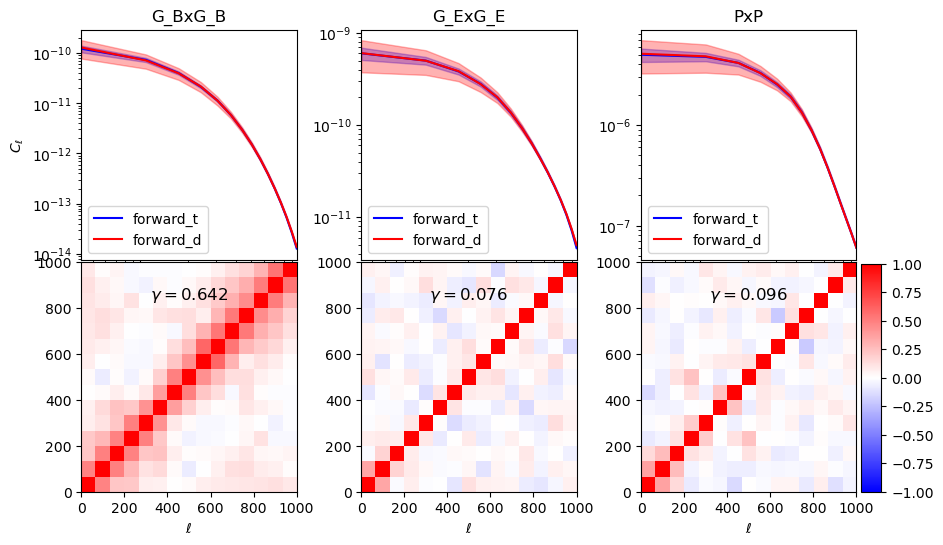

In [40]:
plot_wcovs(for_cls, for_covs, for_dness, save_to="{}_forward.pdf".format(mask_type))

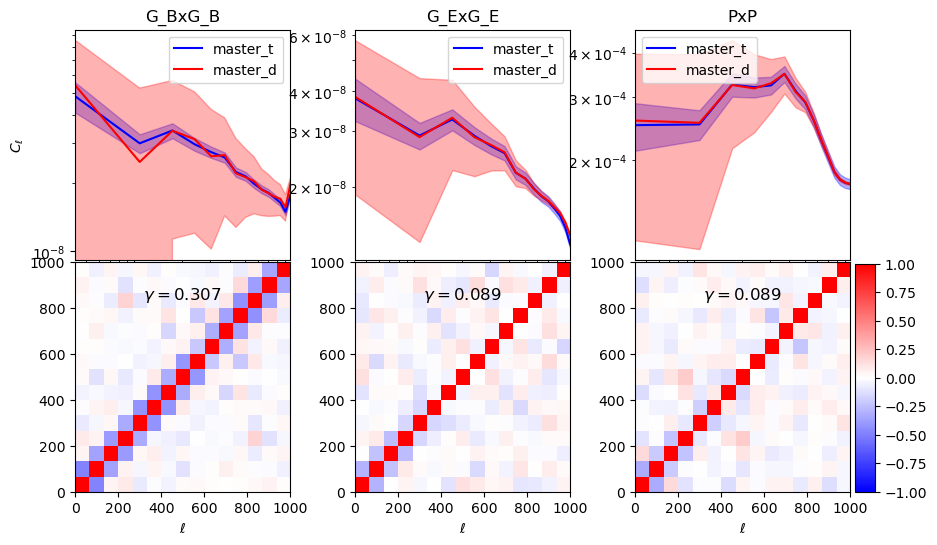

In [41]:
plot_wcovs(master_cls, master_covs, master_dness, save_to="{}_master.pdf".format(mask_type))

/tmp/ipykernel_150215/576584096.py:40: RuntimeWarning: invalid value encountered in divide
  corr = cov/np.outer(err, err)
/tmp/ipykernel_150215/576584096.py:44: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axis[0, i].set_yscale('log')


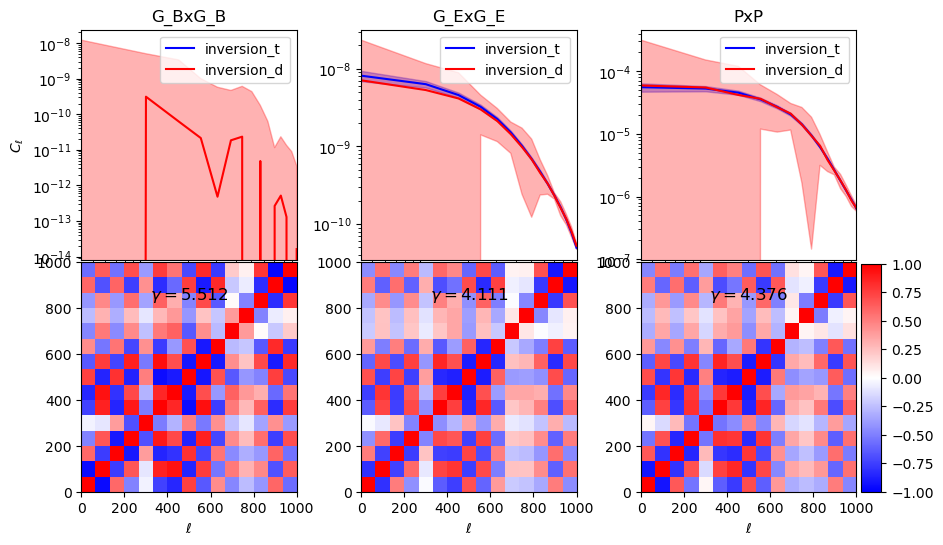

In [42]:
plot_wcovs(inv_cls, inv_covs, inv_dness, save_to="{}_inversion.pdf".format(mask_type))

/tmp/ipykernel_150215/576584096.py:40: RuntimeWarning: invalid value encountered in divide
  corr = cov/np.outer(err, err)
/tmp/ipykernel_150215/576584096.py:44: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axis[0, i].set_yscale('log')


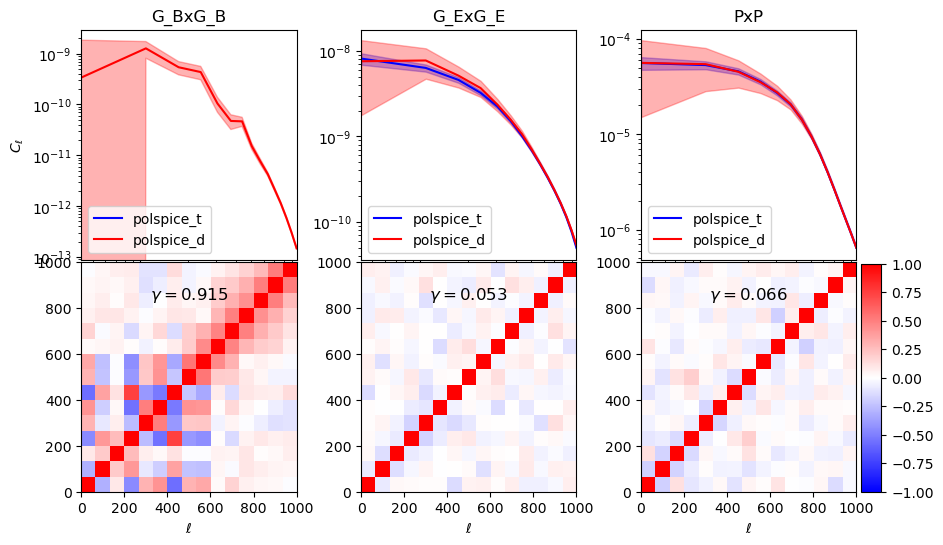

In [43]:
plot_wcovs(polspice_cls, polspice_covs, polspice_dness, save_to="{}_polspice.pdf".format(mask_type))

/tmp/ipykernel_150215/576584096.py:40: RuntimeWarning: invalid value encountered in divide
  corr = cov/np.outer(err, err)
/tmp/ipykernel_150215/576584096.py:44: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axis[0, i].set_yscale('log')


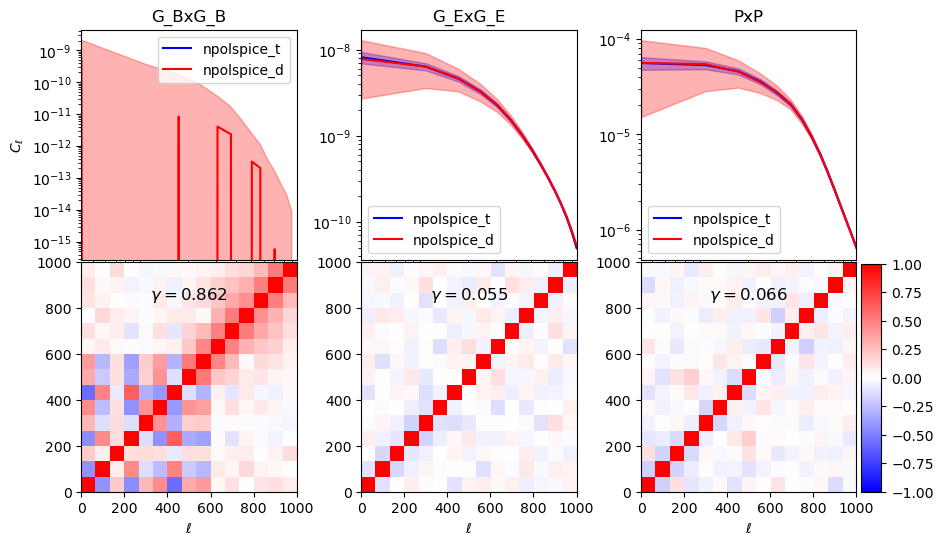

In [44]:
plot_wcovs(npolspice_cls, npolspice_covs, npolspice_dness, save_to="{}_npolspice.pdf".format(mask_type))

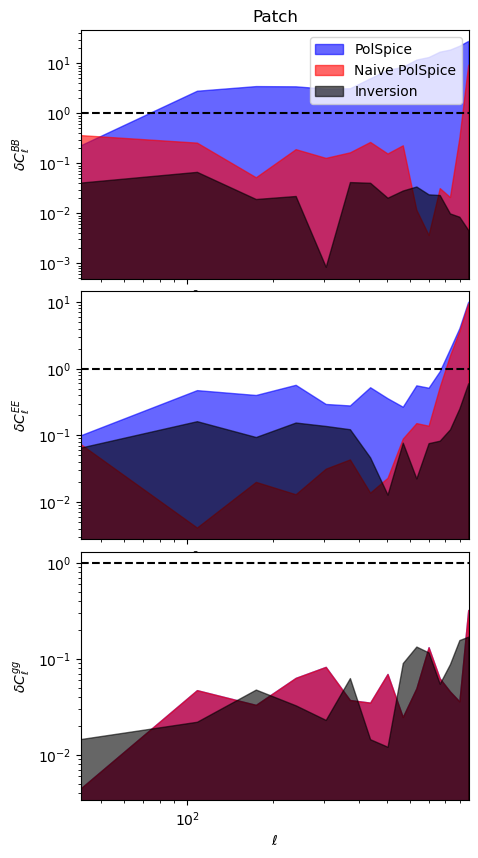

In [45]:
labels = [r'$\delta C_\ell^{BB}$', r'$\delta  C_\ell^{EE}$', r'$\delta  C_\ell^{gg}$']

fig, axis = plt.subplots(3, 1, figsize=(5, 5*2))
fig.subplots_adjust(hspace=0.05)
fig.subplots_adjust(wspace=0)
for i, s1 in enumerate(fields_a):
    proposed_key = (s1, s1, 0, 0)
    t = inversion_t__m[proposed_key]
    d = forward_d__m[proposed_key]
    fors = forward_t__m[proposed_key]
    invs = inversion_d__m[proposed_key]
    pols = polspice_d__m[proposed_key]
    npols = npolspice_d__m[proposed_key]
    master_t = master_t__m[proposed_key]
    master_d = master_d__m[proposed_key]

    invs_cov = inversion_d__cov[proposed_key]
    invs_err = np.sqrt(np.diag(invs_cov))
    pols_cov = polspice_d__cov[proposed_key]
    pols_err = np.sqrt(np.diag(pols_cov))
    npols_cov = npolspice_d__cov[proposed_key]
    npols_err = np.sqrt(np.diag(npols_cov))

    inversion_comp =   np.abs(invs - t)/(invs_err)
    pols_comp =        np.abs(pols - t)/(pols_err)
    naive_pols_comp =  np.abs(npols - t)/(npols_err)

    axis[i].plot(B @ l, np.ones(len(B@l)), 'k--')
    axis[i].fill_between(B @ l, np.zeros(len(B@l)), pols_comp, color='b', alpha=0.6, label="PolSpice")
    axis[i].fill_between(B @ l, np.zeros(len(B@l)), naive_pols_comp, color='r', alpha=0.6, label="Naive PolSpice")
    axis[i].fill_between(B @ l, np.zeros(len(B@l)), inversion_comp, color='k', alpha=0.6, label="Inversion")
    
    axis[i].set_xlim(np.min(B @ l), np.max(B @ l))
    axis[i].set_xscale('log')
    axis[i].set_yscale('log')
    axis[i].set_xlabel(r"$\ell$")
    axis[i].set_ylabel(labels[i])
    #axis[i].grid()

    axis[0].legend()
    axis[0].set_title("Patch")

plt.savefig("/home/jaimerz/Desktop/deconvolve_paper/{}_comp_cl.pdf".format(mask_type))
plt.show()

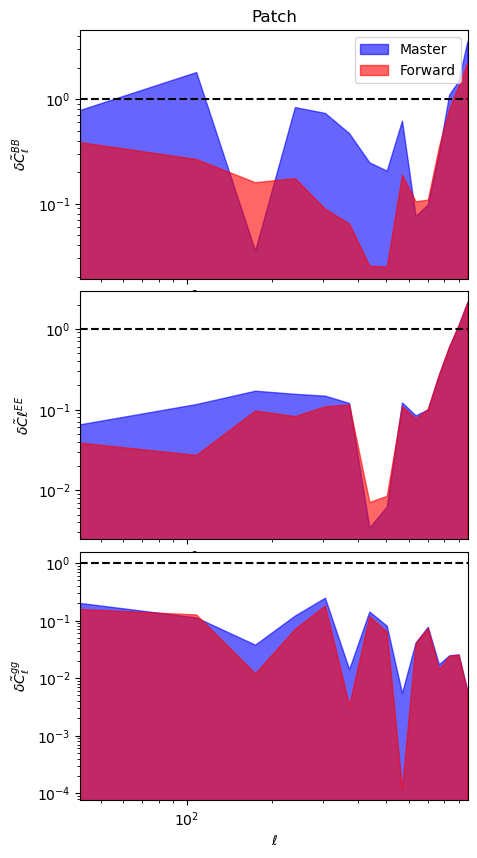

In [46]:
labels = [r'$\delta \tilde{C}_\ell^{BB}$', r'$\delta  \tilde{C}\ell^{EE}$', r'$\delta  \tilde{C}_\ell^{gg}$']

fig, axis = plt.subplots(3, 1, figsize=(5, 5*2))
fig.subplots_adjust(hspace=0.05)
fig.subplots_adjust(wspace=0)
for i, s1 in enumerate(fields_a):
    proposed_key = (s1, s1, 0, 0)
    t = inversion_t__m[proposed_key]
    d = forward_d__m[proposed_key]
    fors = forward_t__m[proposed_key]
    master_t = master_t__m[proposed_key]
    master_d = master_d__m[proposed_key]

    fors_cov = forward_t__cov[proposed_key]
    fors_err = np.sqrt(np.diag(fors_cov))
    master_cov = master_t__cov[proposed_key]
    master_err = np.sqrt(np.diag(master_cov))

    forward_comp = np.abs(d - fors)/(fors_err)
    master_comp =  np.abs(master_d - master_t)/(master_err)

    axis[i].plot(B @ l, np.ones(len(B@l)), 'k--')
    axis[i].fill_between(B @ l, np.zeros(len(B@l)), master_comp, color='b', alpha=0.6, label="Master")
    axis[i].fill_between(B @ l, np.zeros(len(B@l)), forward_comp, color='r', alpha=0.6, label="Forward")
    
    axis[i].set_xlim(np.min(B @ l), np.max(B @ l))
    axis[i].set_xscale('log')
    axis[i].set_yscale('log')
    axis[i].set_xlabel(r"$\ell$")
    axis[i].set_ylabel(labels[i])
    #axis[i].grid()

    axis[0].legend()
    axis[0].set_title("Patch")

plt.savefig("/home/jaimerz/Desktop/deconvolve_paper/{}_comp_cl_tilde.pdf".format(mask_type))
plt.show()